In [1]:
import sys

from collections import namedtuple
from typing import List
from enum import Enum

from hp.core.common import classify_p_in_grid, GridPointType, generate_neighbours, compute_position_match, \
    wrap_compute_count_pairs, generate_unique_edge, compute_position_match, Edge, Corner, GridPointType, EdgeLink, SquareGrid

from pulp import LpVariable, LpProblem, LpStatus, LpMaximize, GLPK, value, lpSum


### Chapter 7.2 - Integer Linear Programming in Computational and Systems Biology
Author: Dan Gusfield
Protein Foldering via the HP Model.

In a very simplified form, we can consider proteins as strings consisting of hydrophobic (H) and polar (P) elements, e.g. HHPPHHHPHHPH.
For this problem, the orientation of a protein is important; e.g. HPP is considered distinct from PPH. Thus, there are distinct proteins consisting of elements.
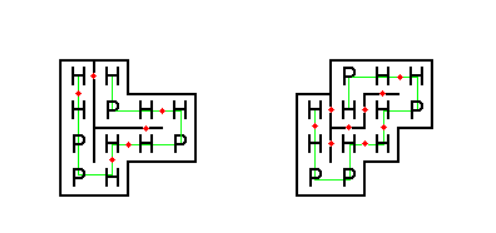
When one encounters these strings in nature, they are always folded in such a way that the number of H-H contact points is as large as possible, since this is energetically advantageous.
As a result, the H-elements tend to accumulate in the inner part, with the P-elements on the outside.
Natural proteins are folded in three dimensions of course, but we will only consider protein folding in two dimensions.

In [12]:
# setup LpProblem with sample Protein number of grid points

prob = LpProblem('Protein_Folding_HP_Model', LpMaximize)
protein = """100000110000100"""
n = len(protein)

# we given each point in the n * n grid an identifer n**2
i_n_by_n = [f'x_i_p_{i}_{p}' for i in range(1, n+1) for p in range(1, n**2+1)]

# i position in the protein string on any point in the n ** n grid 
i_assigned_p_var = LpVariable.dicts("x_i_p", \
                                i_n_by_n, \
                                lowBound=0, \
                                upBound=1, \
                                cat='Integer')

for i in range(1, n+1):
    prob += lpSum([i_assigned_p_var[f'x_i_p_{i}_{p}'] \
        for p in range(1, n**2+1)]) == 1

# ensure that no point on the grid is assigned more than one position in the
# string; for each pair of positions i,j in the string; no grid point 

for p in range(1, n**2+1):
    prob += lpSum([i_assigned_p_var[f'x_i_p_{i}_{p}'] for i in range(1, n+1)]) <= 1

# ensure connectedness
# need to ensure that adjacent positions on the string are assigned to
# neighbouring points on the grid

for i in range(1,n):
    for p in range(1, n**2+1):
        prob += i_assigned_p_var[f'x_i_p_{i}_{p}'] - lpSum([i_assigned_p_var[f'x_i_p_{i+1}_{q}'] for q in generate_neighbours(p=p, n=n)]) <= 0
       

In [13]:
# inequalities to detect contacts

grid = [ f'i_p_{p}' for p in range(1, n**2+1)]
# i position in the protein string on any point in the n ** n grid 
i_p_var = LpVariable.dicts("i_p", \
                                grid, \
                                lowBound=0, \
                                upBound=1, \
                                cat='Integer')

# for each position in the grid
match_list = compute_position_match(protein=protein)
for p in range(1, n**2+1):
    prob += lpSum([i_assigned_p_var[f'x_i_p_{i}_{p}'] for i in range(1, len(protein)+1) if i in match_list]) - i_p_var[f'i_p_{p}'] == 0
    

In [14]:

edge_list = [f'c_{edge.p}_{edge.q}' for edge in generate_unique_edge(n=n)]
# i position in the protein string on any point in the n ** n grid 
c_p_q_var = LpVariable.dicts("c_p_q", \
                                edge_list, \
                                lowBound=0, \
                                upBound=1, \
                                cat='Integer')

for edge in generate_unique_edge(n=n):
    prob += i_p_var[f'i_p_{edge.p}'] + i_p_var[f'i_p_{edge.q}'] - 2 * c_p_q_var[f'c_{edge.p}_{edge.q}'] >= 0

# objective function
offset = wrap_compute_count_pairs(protein=protein, match='11')
offset_var = LpVariable('offset', lowBound=offset, upBound=offset)
prob += lpSum([c_p_q_var[f'c_{edge.p}_{edge.q}'] for edge in generate_unique_edge(n=n)]) - offset_var


In [ ]:

prob.writeLP("simple.lp")

status = prob.solve(GLPK(msg=0))
print(LpStatus[status])

if LpStatus[status] == 'Optimal':
    print('allocation:', ["%s: (%.2f)"%(v.name, v.varValue) for v in prob.variables() if 'x_i_p' in v.name and v.varValue == 1.0])
    #print('prob.objective',prob.objective, '=', value(prob.objective))
    total = sum([(v.varValue) for v in prob.variables()])

In [ ]:
g = SquareGrid(n=n)
g.render_var(prob=prob, protein=protein)